In [1]:
import tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from pinn import PINN
from network import Network
from optimizer import L_BFGS_B

In [2]:
def mass_cons(network, xy):
    """
    Compute u_x and v_y
    Args:
        xy: network input variables as ndarray.
    Returns:
        (u_x, v_y) as ndarray.
    """

    xy = tf.constant(xy)
    x, y = [ xy[..., i, tf.newaxis] for i in range(xy.shape[-1]) ]
    with tf.GradientTape(persistent=True) as g:
      g.watch(x)
      g.watch(y)

      u_v_p = network(tf.concat([x, y], axis=-1))
      u = u_v_p[..., 0, tf.newaxis]
      v = u_v_p[..., 1, tf.newaxis]
      p = u_v_p[..., 2, tf.newaxis]
    u_x = g.batch_jacobian(u, x)[..., 0]
    v_y = g.batch_jacobian(v, y)[..., 0]

    return u_x.numpy(), v_y.numpy()


In [3]:
def u_0(xy):
    """
    Initial wave form.
    Args:
        tx: variables (t, x) as tf.Tensor.
    Returns:
        u(t, x) as tf.Tensor.
    """

    x = xy[..., 0, None]
    y = xy[..., 1, None]


    return    4*y*(1 - y) 


In [4]:
def contour(x, y, z, title, levels=100):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    vmin = np.min(z)
    vmax = np.max(z)
    # plot a contour
    font1 = {'family':'serif','size':20}
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    plt.axes()
    circle = plt.Circle((0.5,0.5),0.1, fc='black')
    plt.gca().add_patch(circle)
    plt.axis('scaled')
    plt.title(title, fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)

    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)



In [ ]:
if __name__ == '__main__':
    """
    Test the physics informed neural network (PINN) model
    for the cavity flow governed by the steady Navier-Stokes equation.
    """

    # number of training samples
    num_train_samples = 5000
    # number of test samples
    num_test_samples = 200

    # inlet flow velocity
    u0 = 1
    # density
    rho = 1
    # viscosity
    mu = 1e-1
    # Re = (L*u0*rho)/mu ==> rho/mu = 10

    # build a core network model
    network = Network().build()
    network.summary()
    # build a PINN model
    pinn = PINN(network, rho=rho, mu=mu).build()

    # Domain and circle data
    x_f =2
    x_ini=0
    y_f=1
    y_ini=0
    Cx = 0.5
    Cy = 0.5
    a = 0.1
    b = 0.1

    xyt_circle = np.random.rand(num_train_samples, 2)
    xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
    xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
    xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

    # create training input
    xyt_eqn = np.random.rand(num_train_samples, 2)
    xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
    xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

    for i in range(num_train_samples):
      while (xyt_eqn[i, 0] - Cx)**2/a**2 + (xyt_eqn[i, 1] - Cy)**2/b**2 < 1:
        xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
        xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini

    xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
    xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
    xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1

    xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
    xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
    xyt_w2[..., 1] =  y_f

    xyt_out = np.random.rand(num_train_samples, 2)  # left-right boundaries
    xyt_out[..., 0] = x_f

    xyt_in = np.random.rand(num_train_samples, 2)
    xyt_in[...,0] = x_ini

    x_train = [xyt_eqn, xyt_w1, xyt_w2, xyt_out, xyt_in, xyt_circle]

    # create training output
    zeros = np.zeros((num_train_samples, 3))
    #uv_bnd[..., 0] = -u0 * np.floor(xy_bnd[..., 0]) +1
    #ones = np.ones((num_train_samples, 3))
    #onze = np.random.rand(num_train_samples, 3)
    #onze[...,0] = u0
    #onze[...,1] = 0
    #onze[...,2] = u0
    a = u_0(tf.constant(xyt_in)).numpy()
    b = np.zeros((num_train_samples, 1))
    onze = np.random.permutation(np.concatenate([a,b,a],axis = -1))

    y_train = [zeros, onze, zeros, zeros, zeros, zeros]
    # train the model using L-BFGS-B algorithm
    lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
    lbfgs.fit()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 48)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_3 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 147       
Total params: 7,347
Trainable params: 7,347
Non-trainable params: 0
___________________________________________________________

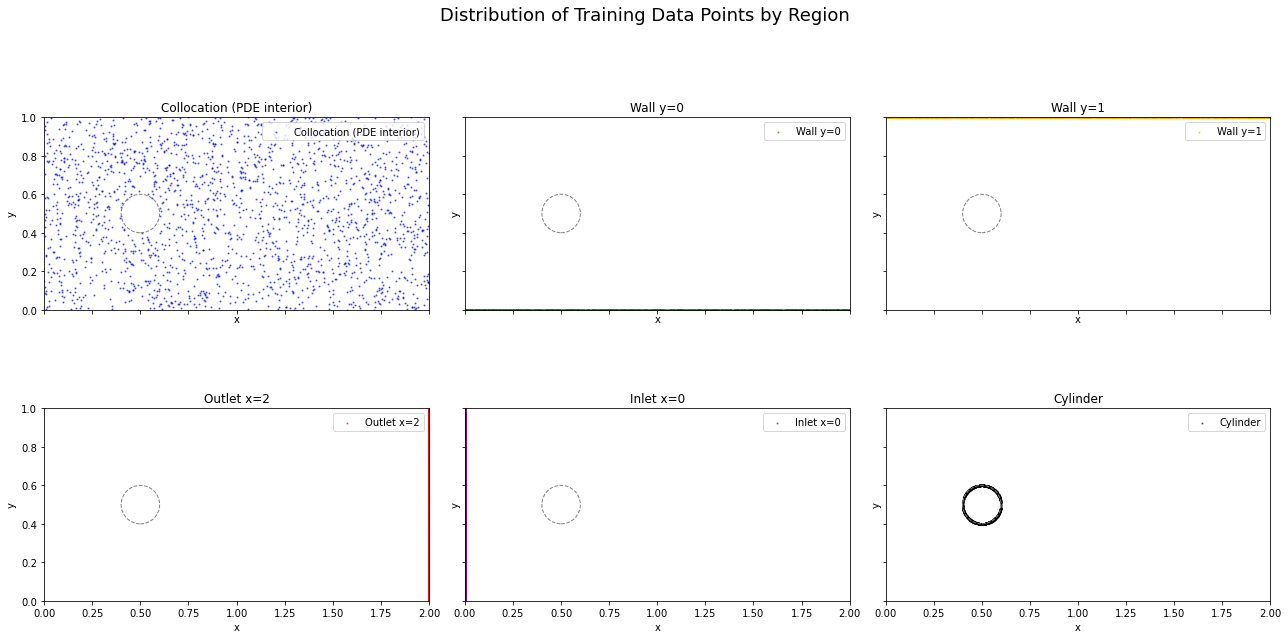

In [13]:
 # --- Plot training data distribution ---
    import matplotlib.pyplot as plt

    # Subsample for clarity if too many points
    def subsample(arr, max_points=2000):
        if arr.shape[0] > max_points:
            idx = np.random.choice(arr.shape[0], max_points, replace=False)
            return arr[idx]
        return arr

    # Prepare data for plotting
    data_labels = [
        ("Collocation (PDE interior)", xyt_eqn),
        ("Wall y=0", xyt_w1),
        ("Wall y=1", xyt_w2),
        ("Outlet x=2", xyt_out),
        ("Inlet x=0", xyt_in),
        ("Cylinder", xyt_circle)
    ]
    colors = ['blue', 'green', 'orange', 'red', 'purple', 'black']
    markers = ['.', '.', '.', '.', '.', '.']

    fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
    axs = axs.flatten()
    for i, (label, data) in enumerate(data_labels):
        arr = subsample(data)
        axs[i].scatter(arr[:, 0], arr[:, 1], s=5, c=colors[i], alpha=0.5, marker=markers[i], label=label)
        axs[i].set_title(label)
        axs[i].set_xlim([0, 2])
        axs[i].set_ylim([0, 1])
        axs[i].set_aspect('equal')
        axs[i].set_xlabel('x')
        axs[i].set_ylabel('y')
        axs[i].legend(loc='best', fontsize=10)
        # Draw cylinder for reference
        circle = plt.Circle((0.5, 0.5), 0.1, color='gray', fill=False, linestyle='--')
        axs[i].add_patch(circle)
    plt.suptitle("Distribution of Training Data Points by Region", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

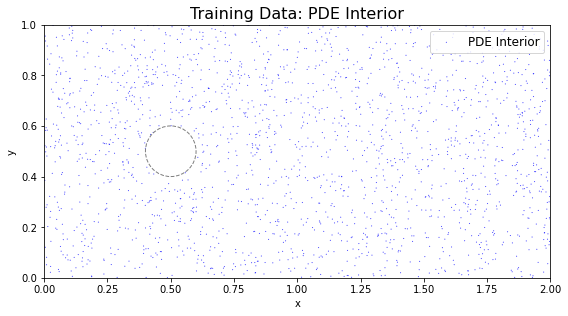

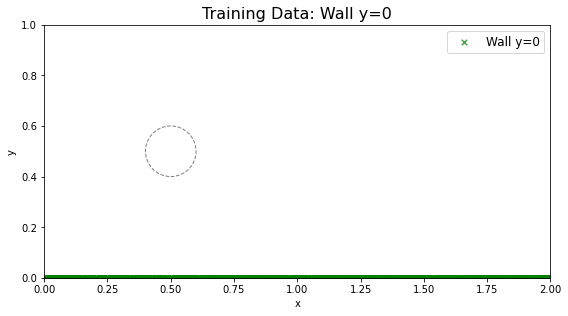

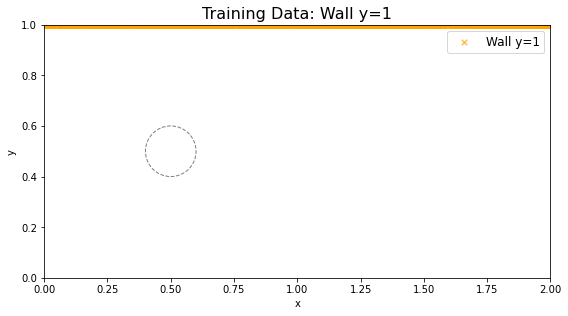

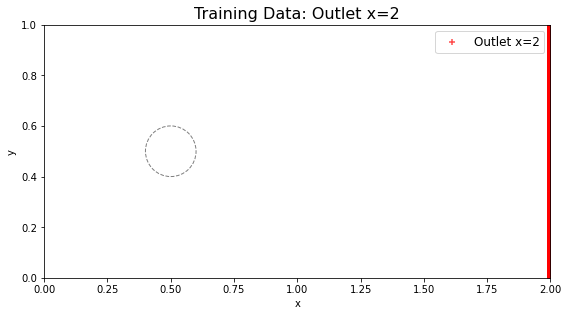

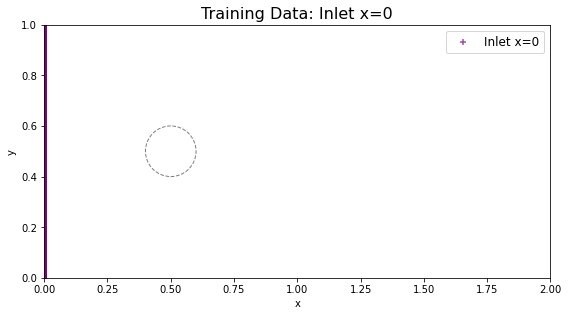

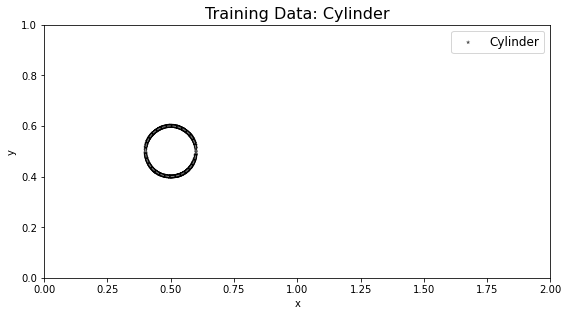

In [16]:
# --- Plot training data distribution (separate plots, distinct markers) ---
    import matplotlib.pyplot as plt

    def subsample(arr, max_points=2000):
        if arr.shape[0] > max_points:
            idx = np.random.choice(arr.shape[0], max_points, replace=False)
            return arr[idx]
        return arr

    data_labels = [
        ("PDE Interior", xyt_eqn, 'blue', '.', 5),
        ("Wall y=0", xyt_w1, 'green', 'x', 30),
        ("Wall y=1", xyt_w2, 'orange', 'x', 30),
        ("Outlet x=2", xyt_out, 'red', '+', 30),
        ("Inlet x=0", xyt_in, 'purple', '+', 30),
        ("Cylinder", xyt_circle, 'black', '*', 20)
    ]

    for label, data, color, marker, size in data_labels:
        arr = subsample(data)
        plt.figure(figsize=(8, 6))
        plt.scatter(arr[:, 0], arr[:, 1], s=size, c=color, alpha=0.7, marker=marker, label=label, edgecolors='none')
        plt.title(f"Training Data: {label}", fontsize=16)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim([0, 2])
        plt.ylim([0, 1])
        plt.gca().set_aspect('equal')
        plt.legend(loc='best', fontsize=12)
        # Draw cylinder for reference
        circle = plt.Circle((0.5, 0.5), 0.1, color='gray', fill=False, linestyle='--')
        plt.gca().add_patch(circle)
        plt.tight_layout()
        plt.show()

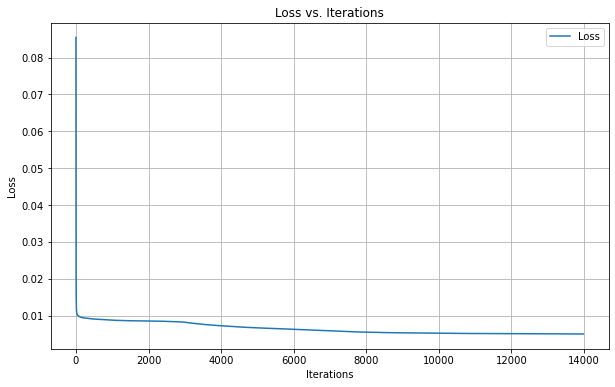

In [6]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(lbfgs.loss_history)), lbfgs.loss_history, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.grid()
plt.show()

In [9]:
def plot_profiles(x, y, u, v, cross_sections):
    """
    Plot velocity profiles (u, v) along specified cross-sections.
    Args:
        x: x-array (meshgrid).
        y: y-array (meshgrid).
        u: u-array (velocity in x-direction).
        v: v-array (velocity in y-direction).
        cross_sections: List of cross-sections to plot. Each cross-section is a tuple (type, value).
                        'type' can be 'x' or 'y', and 'value' is the coordinate value.
                        Example: [('x', 0), ('y', 0), ('y', 1), ('x', 0.75)]
    """
    for section in cross_sections:
        section_type, value = section
        if section_type == 'x':  # Vertical line (constant x)
            idx = np.argmin(np.abs(x[0, :] - value))  # Find the closest x index
            plt.figure(figsize=(8, 6))
            plt.plot(y[:, idx], u[:, idx], label='u (x={})'.format(value))
            plt.plot(y[:, idx], v[:, idx], label='v (x={})'.format(value))
            plt.xlabel('y')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at x = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
        elif section_type == 'y':  # Horizontal line (constant y)
            idx = np.argmin(np.abs(y[:, 0] - value))  # Find the closest y index
            plt.figure(figsize=(8, 6))
            plt.plot(x[idx, :], u[idx, :], label='u (y={})'.format(value))
            plt.plot(x[idx, :], v[idx, :], label='v (y={})'.format(value))
            plt.xlabel('x')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at y = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()

c:\anaconda\envs\pinnpy_3.6\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


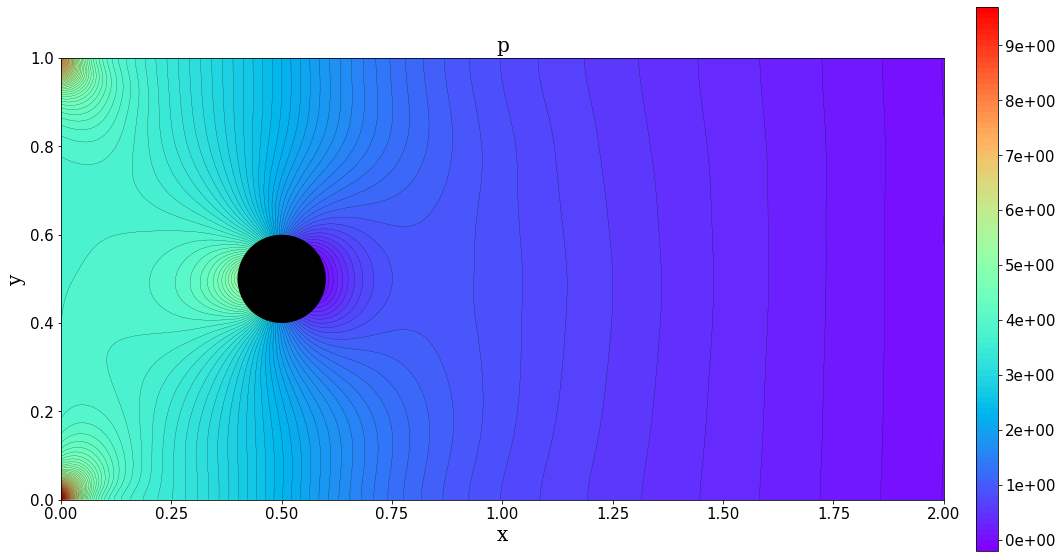

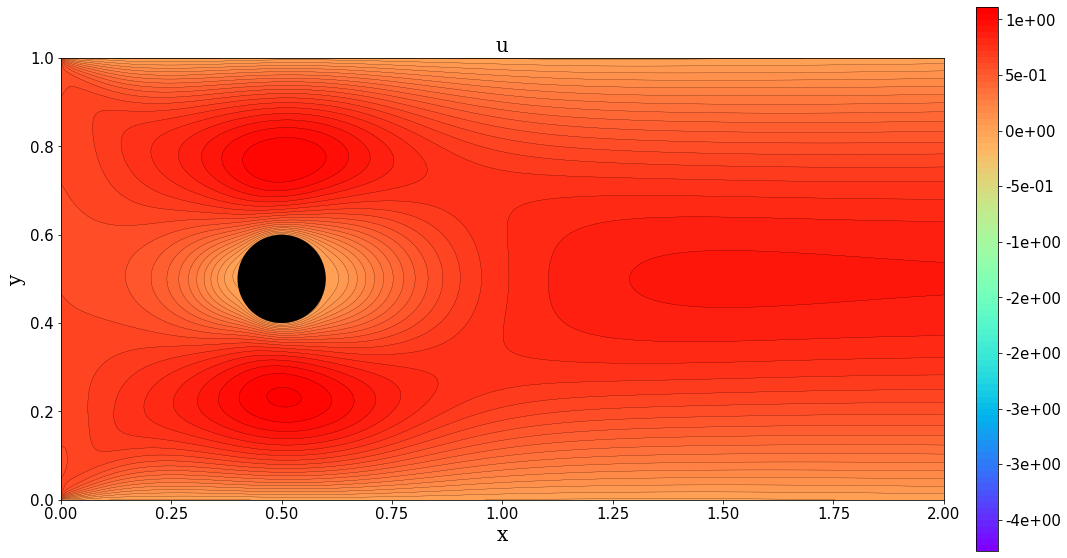

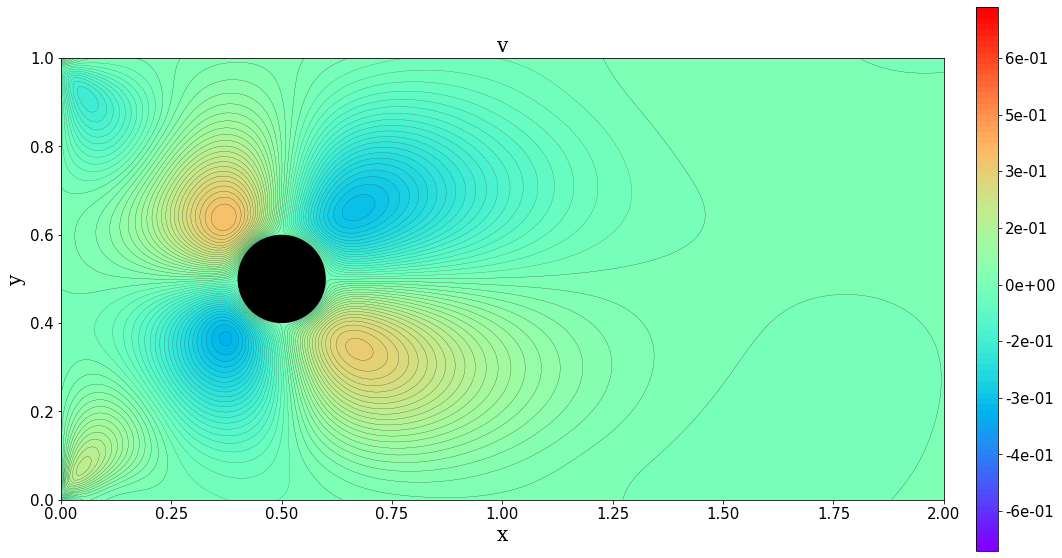

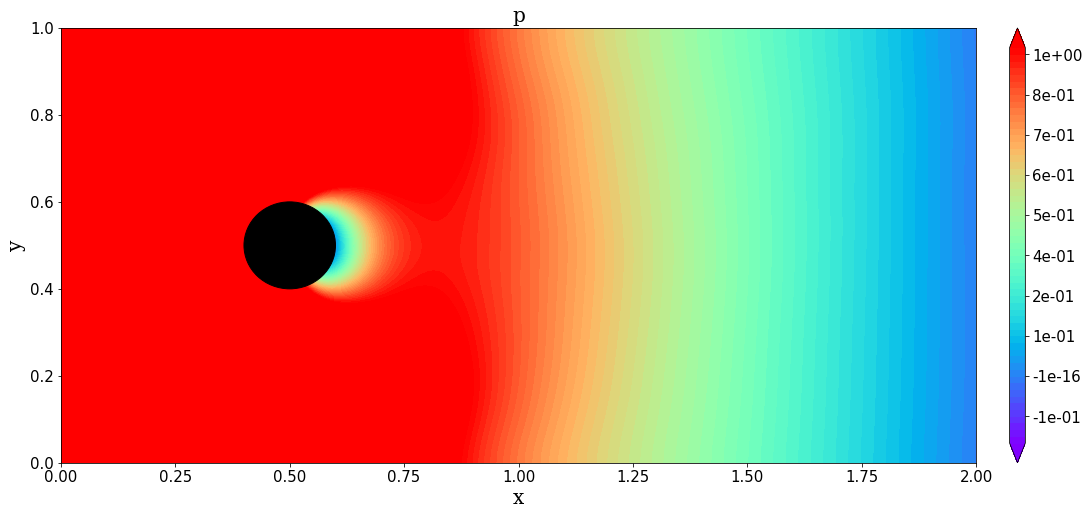

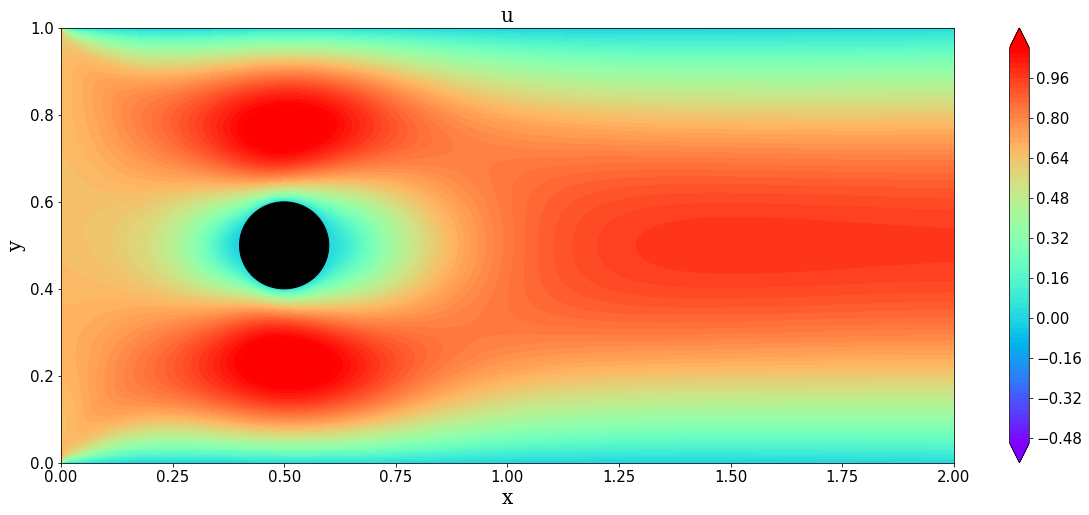

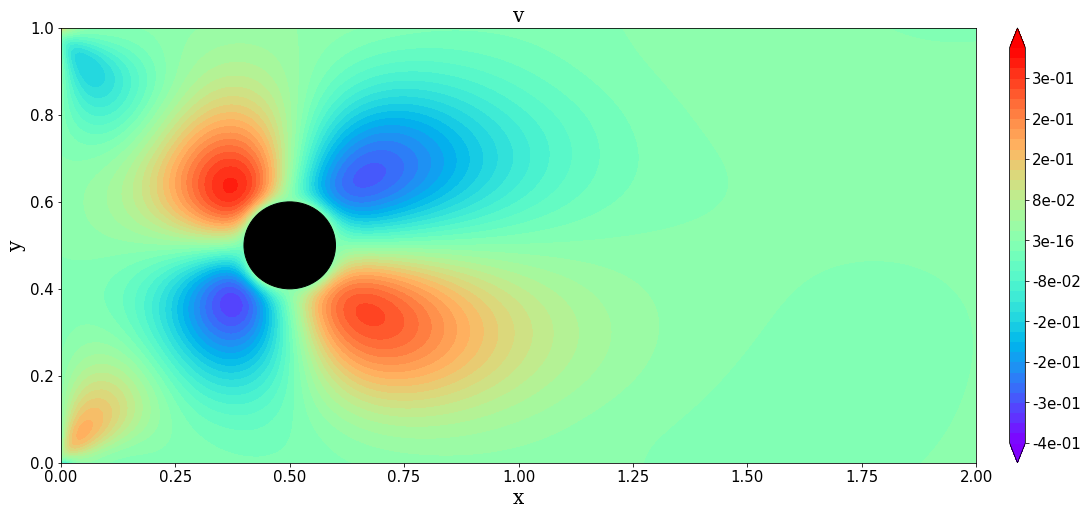

In [33]:

    # create meshgrid coordinates (x, y) for test plots    

    x = np.linspace(x_ini, x_f, num_test_samples)
    y = np.linspace(y_ini, y_f, num_test_samples)
    x, y = np.meshgrid(x, y)
    xy = np.stack([x.flatten(), y.flatten()], axis=-1)
    # predict (psi, p)
    u_v_p = network.predict(xy, batch_size=len(xy))
    u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
    # compute (u, v)
    u = u.reshape(x.shape)
    v = v.reshape(x.shape)
    p = p.reshape(x.shape)
    # plot test results
    fig = plt.figure(figsize=(16, 8))
    contour(x, y, p, 'p')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(16, 8))
    contour(x, y, u, 'u')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(16, 8))
    contour(x, y, v, 'v')
    plt.tight_layout()
    plt.show()
    

    ###########################
    from matplotlib.patches import Circle
    font1 = {'family':'serif','size':20}

    fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
    cf0 = ax0.contourf(x, y, p, np.arange(-0.2, 1, .02),
                   extend='both',cmap='rainbow')
    cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
    plt.title("p", fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar0.ax.tick_params(labelsize=15)
    plt.show()

    ###########################

    fig0, ax0 = plt.subplots(1, 1, figsize=(20,8))
    cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
                   extend='both',cmap='rainbow')
    cbar0 = plt.colorbar(cf0, )
    plt.title("u", fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar0.ax.tick_params(labelsize=15)
    plt.show()

    ###########################

    fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
    cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
                   extend='both',cmap='rainbow')
    cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
    plt.title("v", fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar0.ax.tick_params(labelsize=15)
    plt.show()

    ############################ 


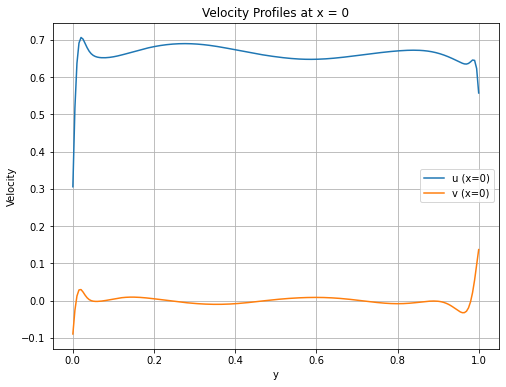

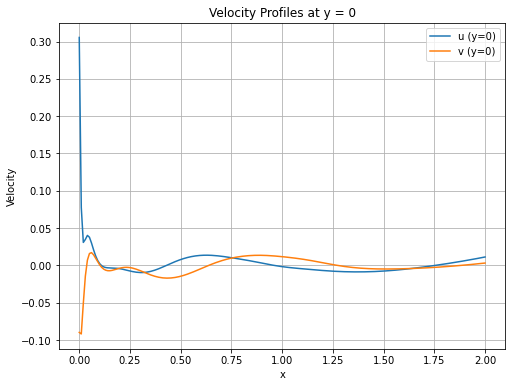

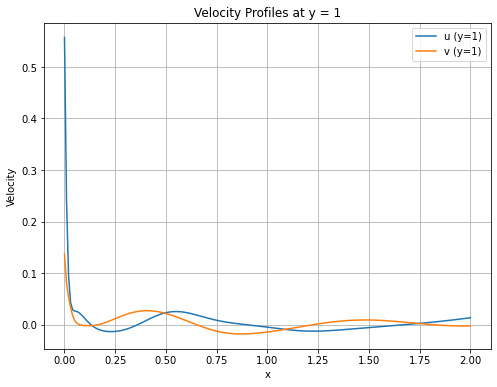

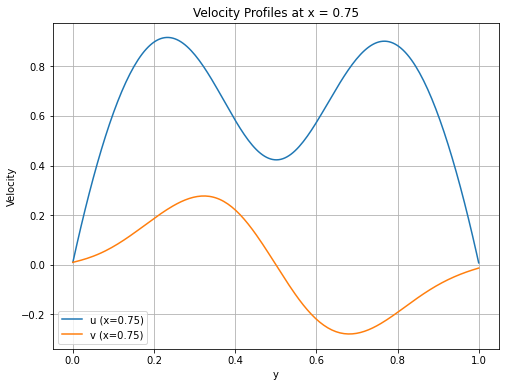

In [12]:
# Plot velocity profiles along specified cross-sections
cross_sections = [('x', 0), ('y', 0), ('y', 1), ('x', 0.75)]
plot_profiles(x, y, u, v, cross_sections)


c:\anaconda\envs\pinnpy_3.6\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


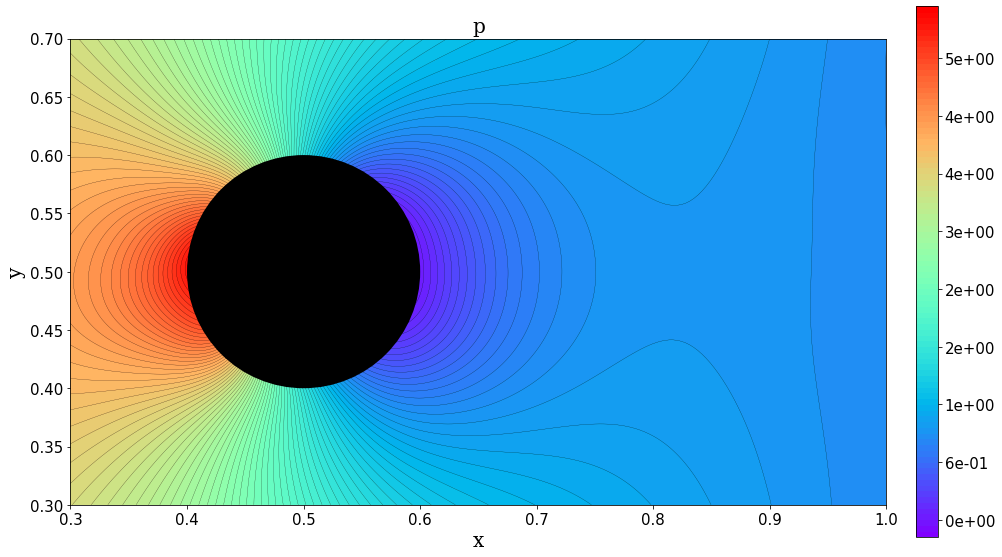

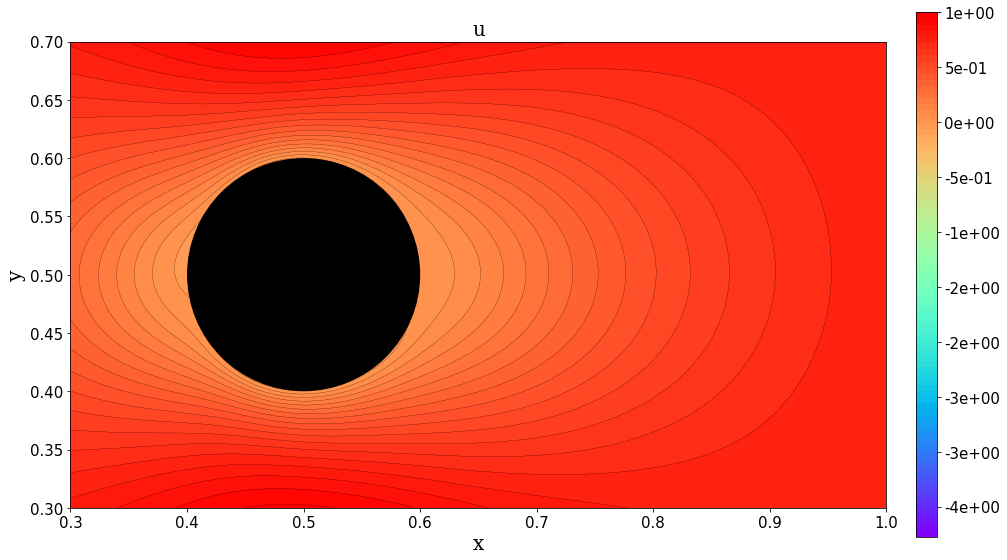

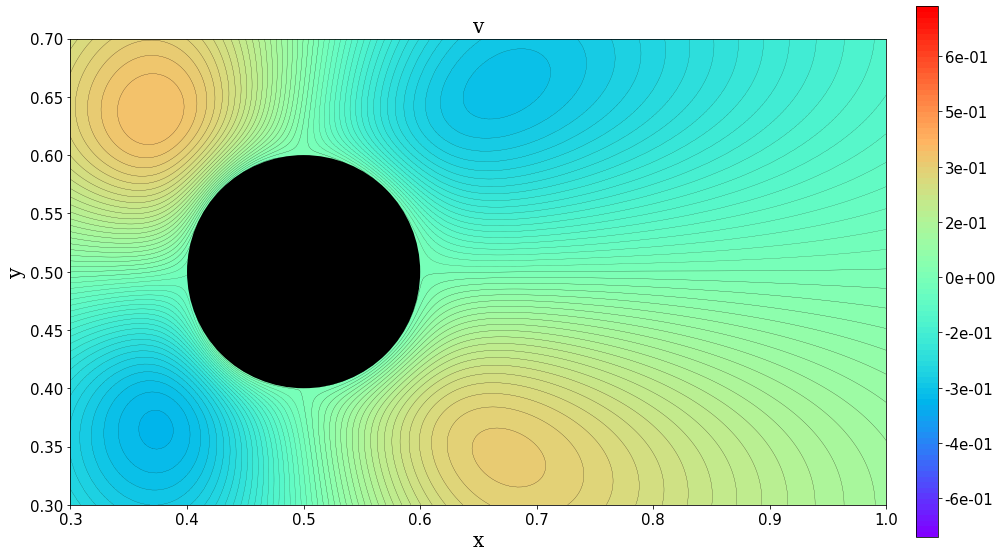

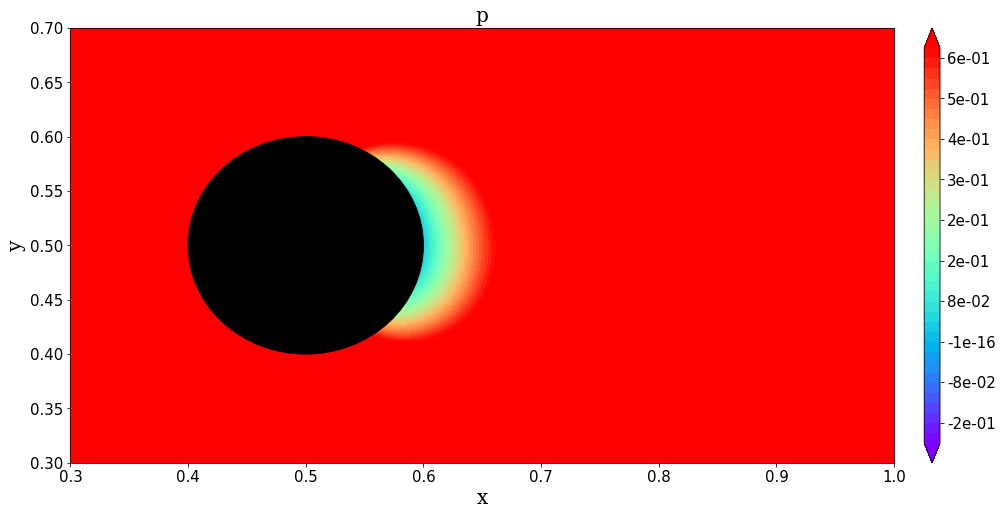

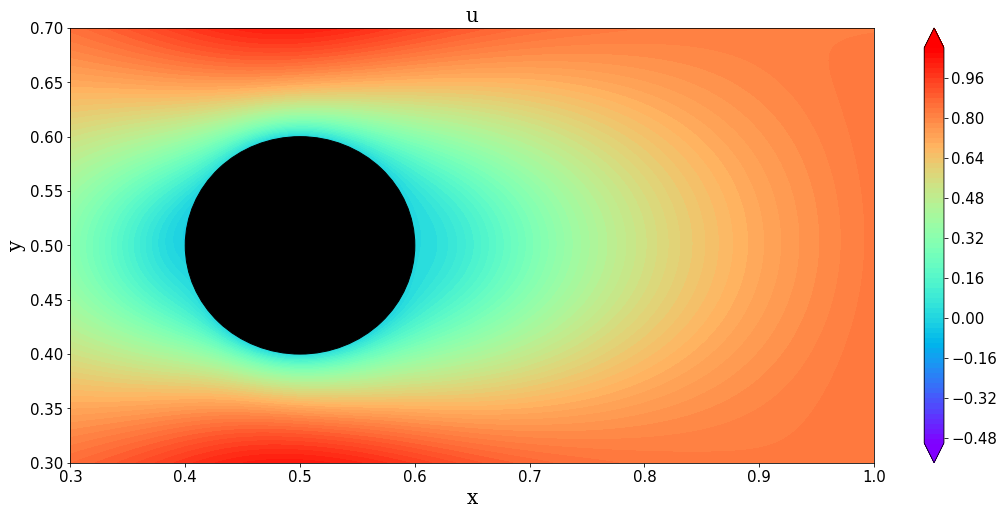

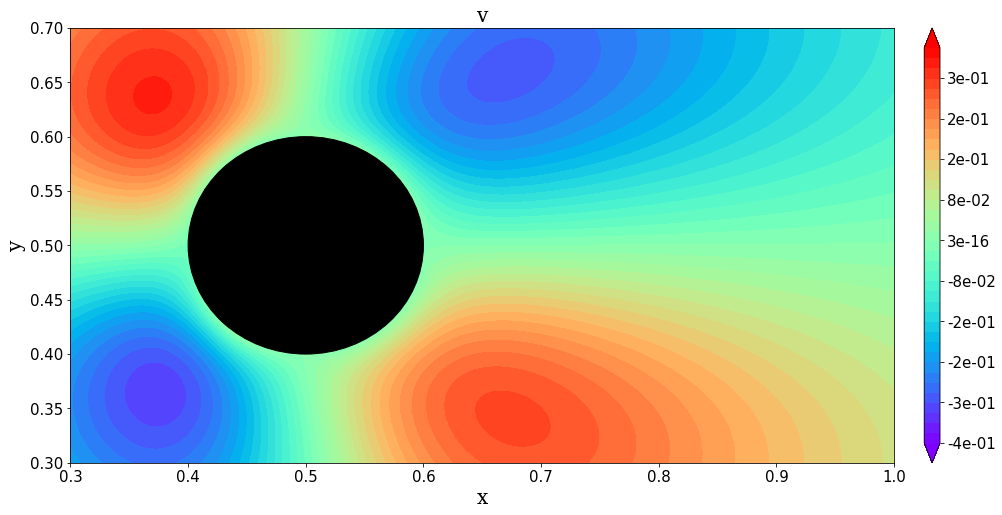

In [19]:

    x = np.linspace(0.3, 1, num_test_samples)
    y = np.linspace(0.3, 0.7, num_test_samples)
    x, y = np.meshgrid(x, y)
    xy = np.stack([x.flatten(), y.flatten()], axis=-1)
    # predict (psi, p)
    u_v_p = network.predict(xy, batch_size=len(xy))
    u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
    # compute (u, v)
    u = u.reshape(x.shape)
    v = v.reshape(x.shape)
    p = p.reshape(x.shape)
    # plot test results
    
    fig = plt.figure(figsize=(15, 8))
    #contour(gs[0, 0], x, y, psi, 'psi')
    contour(x, y, p, 'p')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(15, 8))
    contour(x, y, u, 'u')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(15, 8))
    contour(x, y, v, 'v')
    plt.tight_layout()
    plt.show()

    ###########################
    from matplotlib.patches import Circle
    font1 = {'family':'serif','size':20}

    fig0, ax0 = plt.subplots(1, 1,figsize=(18,8))
    cf0 = ax0.contourf(x, y, p, np.arange(-0.2, 0.6, .02),
                   extend='both',cmap='rainbow')
    cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
    plt.title("p", fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar0.ax.tick_params(labelsize=15)
    plt.show()

    ###########################

    fig0, ax0 = plt.subplots(1, 1, figsize=(18,8))
    cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
                   extend='both',cmap='rainbow')
    cbar0 = plt.colorbar(cf0, )
    plt.title("u", fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar0.ax.tick_params(labelsize=15)
    plt.show()

    ###########################

    fig0, ax0 = plt.subplots(1, 1,figsize=(18,8))
    cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
                   extend='both',cmap='rainbow')
    cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
    plt.title("v", fontdict = font1)
    plt.xlabel("x", fontdict = font1)
    plt.ylabel("y", fontdict = font1)
    ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar0.ax.tick_params(labelsize=15)
    plt.show()


In [20]:
! pip install pandas

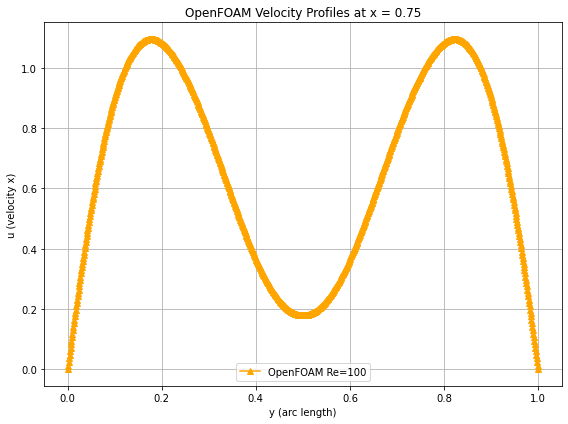

In [25]:

import pandas as pd

# ux_re10 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re10_Med_Ux\Re10_Med_Ux_0.75.csv"
ux_re100 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re100_Med_Ux\Re100_Med_Ux_0.75.csv"
# ux_re1000 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re1000_Med_Ux\Re1000_Med_Ux_0.75.csv"

# Read CSVs (assume columns: arc_length, U_X)
# df_re10 = pd.read_csv(ux_re10)
df_re100 = pd.read_csv(ux_re100)
# df_re1000 = pd.read_csv(ux_re1000)

# Plot OpenFOAM velocity profiles at x=0.75 for different Reynolds numbers
plt.figure(figsize=(8, 6))
# plt.plot(df_re10["arc_length"], df_re10["U_X"], label="OpenFOAM Re=10", color="green", marker="o")
plt.plot(df_re100["arc_length"], df_re100["U_X"], label="OpenFOAM Re=100", color="orange", marker="^")
# plt.plot(df_re1000["arc_length"], df_re1000["U_X"], label="OpenFOAM Re=1000", color="red", marker="s")
plt.xlabel("y (arc length)")
plt.ylabel("u (velocity x)")
plt.title("OpenFOAM Velocity Profiles at x = 0.75")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

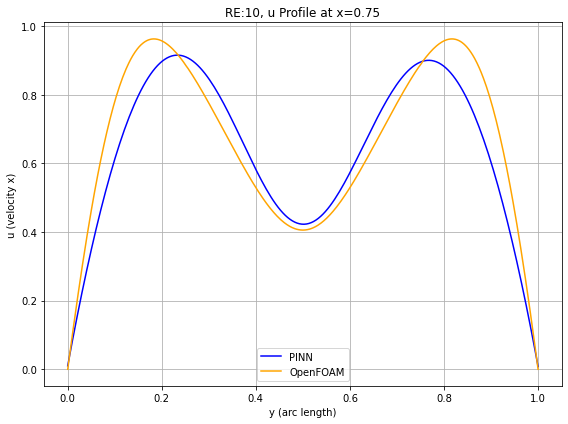

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_profile_comparison(y_pinn, u_pinn, y_ref, u_ref, label_pinn="PINN", label_ref="OpenFOAM", title="Velocity Profile Comparison"):
    """
    Plot and compare two velocity profiles along the same cross-section.
    Args:
        y_pinn: y-coordinates for PINN data.
        u_pinn: velocity values for PINN data.
        y_ref: y-coordinates for reference data (e.g., OpenFOAM).
        u_ref: velocity values for reference data.
        label_pinn: label for PINN data.
        label_ref: label for reference data.
        title: plot title.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(y_pinn, u_pinn, label=label_pinn, color='blue')
    plt.plot(y_ref, u_ref, label=label_ref, color='orange')
    plt.xlabel('y (arc length)')
    plt.ylabel('u (velocity x)')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# to compare at x=0.75
x_target = 0.75
idx = np.argmin(np.abs(x[0, :] - x_target))
y_pinn = y[:, idx]
u_pinn = u[:, idx]

# Load OpenFOAM reference data
df_re100 = pd.read_csv(r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re10_Med_Ux\Re10_Med_Ux_0.75.csv")
y_ref = df_re100["arc_length"]
u_ref = df_re100["U_X"]

plot_profile_comparison(y_pinn, u_pinn, y_ref, u_ref, label_pinn="PINN", label_ref="OpenFOAM", title="RE:10, u Profile at x=0.75")

In [37]:
import numpy as np
from scipy.interpolate import interp1d

# y_pinn, u_pinn: PINN y and u values at x=0.75
# y_ref, u_ref: OpenFOAM y and u values at x=0.75

# Interpolate PINN profile onto OpenFOAM's y-coordinates
u_pinn_interp = interp1d(y_pinn, u_pinn, kind='linear', bounds_error=False, fill_value='extrapolate')
u_pinn_on_ref = u_pinn_interp(y_ref)

# Compute errors
mae = np.mean(np.abs(u_pinn_on_ref - u_ref))
rmse = np.sqrt(np.mean((u_pinn_on_ref - u_ref)**2))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0741
RMSE: 0.0903
